In [1]:
# Import used modules
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [3]:
# Generating Train data
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 30,
                                                             width_shift_range = 0.1,
                                                             height_shift_range = 0.1,
                                                             brightness_range = [0.2, 1.2],
                                                             horizontal_flip = True,
                                                             zoom_range=0.2).flow_from_directory(r"FER2013\train",
                                                                                   target_size=(48, 48),
                                                                                   color_mode='grayscale')

Found 28267 images belonging to 6 classes.


In [4]:
# Generating Test data
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 30,
                                                             width_shift_range = 0.1,
                                                             height_shift_range = 0.1,
                                                             brightness_range = [0.2, 1.2],
                                                             horizontal_flip = True,
                                                             zoom_range=0.2).flow_from_directory(r"FER2013\test",
                                                                                   target_size=(48, 48),
                                                                                   color_mode='grayscale')

Found 7067 images belonging to 6 classes.


# CNN model

In [5]:
def CNN_EmotionRecognition(input_shape, Emotions_number):
    """Convolutional Neural Network architecture for Emotion Recognition
    Args:
        input_shape (tuple): tuple with the input of the CNN 
        Emotions_number (int): The number of predictions emotions 

    Returns:
        Keras Model: model 
    """
    input = Input(shape = input_shape)
    # First block
    conv1 = Conv2D(32, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001), activation = "relu")(input)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
    bn = BatchNormalization()(pool1)
    # Second block
    conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001), activation = "silu")(bn)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
    bn = BatchNormalization()(pool2)
    # Third block
    conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001), activation = "silu")(bn)
    conv3 = Dropout(0.1)(conv3)
    pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
    bn = BatchNormalization()(pool3)
    # Fourth block
    conv4 = Conv2D(256, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001), activation = "silu")(bn)
    conv4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size = (2,2))(conv4)
    bn = BatchNormalization()(pool4)
    # Fifth block
    conv5 = Conv2D(128,(5, 5), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001), activation = "silu")(bn)
    conv5 = Dropout(0.1)(conv5)
    pool5 = MaxPooling2D(pool_size = (2,2))(conv5)

    flatten = Flatten()(pool5)
    # First dense block
    dense_1 = Dense(512, activation = "silu")(flatten)
    drop_2 = Dropout(0.2)(dense_1)
    bn = BatchNormalization()(drop_2)
    # Second dense block
    dense_2 = Dense(256, activation = "gelu")(bn)
    drop_2 = Dropout(0.2)(dense_2)
    bn = BatchNormalization()(drop_2)

    output = Dense(Emotions_number, activation="softmax")(bn)

    model = Model(inputs=input, outputs=output)
    
    return model

In [6]:
# Call the model
model = CNN_EmotionRecognition((48, 48, 1), 6)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496 

In [8]:
# Choosing the optimizer and loss function and the metrics
model.compile(optimizer="adam", loss=['CategoricalCrossentropy'], metrics=['accuracy'])

In [9]:
fle_s='Check_points/CNN_FER13.h5'
# Save the best weights of the model during the training process monitoring the val_accuracy
checkpointer = ModelCheckpoint(fle_s, monitor='val_accuracy', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')

# Make the model early stops when the val_accuracy does not change into a higher one in the interval of 25 epochs
earlystop = EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=25)

callback_list=[checkpointer, earlystop]

In [10]:
# Training the model on 300 epochs
model_stats = model.fit(train_data, epochs = 300, validation_data = test_data, callbacks=[callback_list])

Epoch 1/300
884/884 [==============================] - ETA: 0s - loss: 2.2192 - accuracy: 0.2242
Epoch 1: val_accuracy improved from -inf to 0.24551, saving model to Check_points\CNN_FER14.h5
884/884 [==============================] - 132s 142ms/step - loss: 2.2192 - accuracy: 0.2242 - val_loss: 1.9814 - val_accuracy: 0.2455
Epoch 2/300
883/884 [============================>.] - ETA: 0s - loss: 1.8706 - accuracy: 0.2902
Epoch 2: val_accuracy improved from 0.24551 to 0.29871, saving model to Check_points\CNN_FER14.h5
884/884 [==============================] - 20s 22ms/step - loss: 1.8707 - accuracy: 0.2901 - val_loss: 1.8145 - val_accuracy: 0.2987
Epoch 3/300
883/884 [============================>.] - ETA: 0s - loss: 1.7334 - accuracy: 0.3693
Epoch 3: val_accuracy improved from 0.29871 to 0.36791, saving model to Check_points\CNN_FER14.h5
884/884 [==============================] - 27s 31ms/step - loss: 1.7333 - accuracy: 0.3693 - val_loss: 1.7415 - val_accuracy: 0.3679
Epoch 4/300
883/8

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

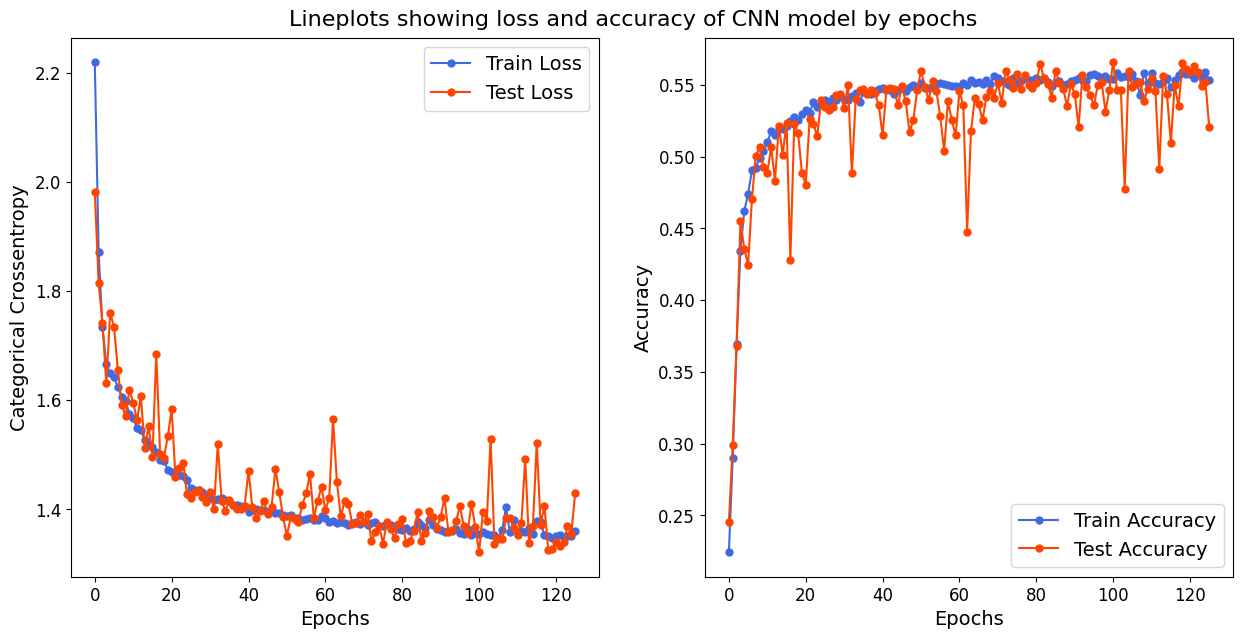

In [11]:
# Checking the train and test loss and accuracy values from the model.
train_loss = model_stats.history['loss']
test_loss = model_stats.history['val_loss']
train_accuracy = model_stats.history['accuracy']
test_accuracy = model_stats.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5);
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5);
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5);
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5);
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16);

In [13]:
# Classification Report
Y_pred = model.predict_generator(test_data, 7067 // 32 + 1)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
target_names = ['Angry', 'Fearful', 'Happy', 'Surprised', 'Natural', 'Sad']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

C:\Users\Saif Elkerdany\AppData\Local\Temp\ipykernel_162612\2896098354.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_data, 7067 // 32 + 1)


Classification Report
              precision    recall  f1-score   support

       Angry       0.14      0.14      0.14       958
     Fearful       0.15      0.09      0.11      1024
       Happy       0.26      0.31      0.29      1774
   Surprised       0.12      0.11      0.11       831
     Natural       0.17      0.18      0.18      1233
         Sad       0.18      0.19      0.18      1247

    accuracy                           0.19      7067
   macro avg       0.17      0.17      0.17      7067
weighted avg       0.18      0.19      0.18      7067



<Axes: >

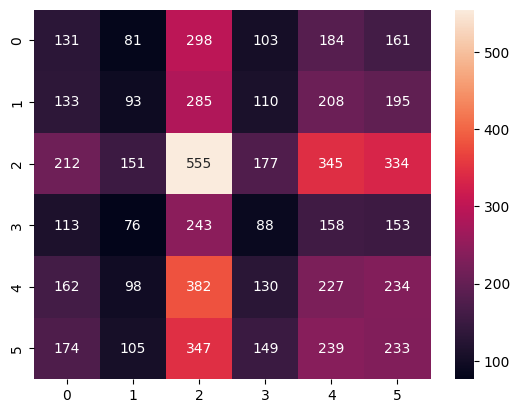

In [19]:
# confusion Matrix
cm = confusion_matrix(test_data.classes, y_pred)

sns.heatmap(cm, annot=True, fmt='')

In [33]:
# Testing the model on real time images 
cap = cv2.VideoCapture(0)
emotion_dic= {0: 'Angry', 1: 'Fearful', 2: 'Happy', 3: 'Surprised', 4: 'Natural', 5: 'Sad'}

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    
    face_detector = cv2.CascadeClassifier(r"haarcascades\haarcascade_frontalface_default.xml")
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor= 1.3, minNeighbors=1)
    
    for(x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (0,255,0), 4)
        roi_gray_frame = gray_frame[y:y+h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1 ), 0)
        
        blur = cv2.GaussianBlur(cropped_img, (1, 1), 0)
        white = cv2.convertScaleAbs(blur, beta = 120)
        
        emotion_pred = model.predict(white)
        maxindex = int(np.argmax(emotion_pred))
        
        cv2.putText(frame, emotion_dic[maxindex], (x + 5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_4 )
    
    cv2.imshow('Emotion Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 12ms/step


In [ ]:
# Saving model
model.save('CNN_FER13_Model.keras')